In [2]:
# !pip install gym
# !pip install gym[box2d]
# !pip install keras
# !pip install matplotlib
# !pip install box2d
# !pip install box2d-py

In [107]:
import tensorflow as tf

import gym

import time
import random
import numpy as np
import pickle

from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

from collections      import deque
import os

from LunarLanderEnv import *

from pathlib import Path

import pickle

import gym_sokoban

In [4]:
def plot_scores(all_scores, names, smooth=20):
    figure, axis = plt.subplots(1, 1,figsize=(6,6))
    if isinstance(all_scores[0][0], tuple):
        for scores, name in zip(all_scores, names):
            xs = [i[0] for i in scores]
            ys = [i[1] for i in scores]
            smoothed_scores = [np.mean(scores[0:i][-smooth:]) for i in range(len(scores))]
            axis.plot(xs[0:len(smoothed_scores)], smoothed_scores, label=name)
    else:
        for scores, name in zip(all_scores, names):
            smoothed_scores = [np.mean(scores[0:i][-smooth:]) for i in range(len(scores))]
            axis.plot(range(len(smoothed_scores)), smoothed_scores, label=name)
#     figure.legend(loc='lower right')
    figure.legend(bbox_to_anchor=(0.8, 0., 0.5, 0.5))

In [26]:
import gym
import random
from keras import Sequential, models
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear


class DQAgent():
    def __init__(self, state_size, action_size, backup_dir, gamma, learning_rate=0.001, memory_size=None):
        self.weight_backup      = "lunar_weight.h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.sample_batch_size  = 64
        if memory_size is None:
            self.memory         = deque(maxlen=self.sample_batch_size)
        else:
            self.memory         = deque(maxlen=memory_size)
        self.learning_rate      = learning_rate
        self.gamma              = gamma
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.999
        self.brain              = self._build_model()
        self.training_scores    = []
        self.validation_scores  = []
        self.episodes_run       = 0
        self.backup_dir         = backup_dir
        
        self.training_scores_graph_file = "Lunar_DQ_training_scores.png"
        if not os.path.exists(self.backup_dir):
            os.mkdir(self.backup_dir)
        
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(200, input_dim=self.state_size, activation=relu))
        model.add(Dense(140, activation=relu))
        model.add(Dense(self.action_size, activation=linear))
#         model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model

    def save_agent(self):
        self.brain.save(Path(self.backup_dir, "model_weights"))
        pickle.dump(self.training_scores, open(Path(self.backup_dir, "training_scores"), "wb"))
        pickle.dump(self.validation_scores, open(Path(self.backup_dir, "validation_scores"), "wb"))
        pickle.dump([self.episodes_run], open(Path(self.backup_dir, "episodes_run"), "wb"))
        smooth = 10
        plt.plot([np.mean(self.training_scores[i:i+smooth]) for i in range(len(self.training_scores) - smooth)])
        plt.savefig(Path(self.backup_dir, self.training_scores_graph_file), facecolor='white')

    def load_agent(self):
        self.brain = models.load_model(Path(self.backup_dir, "model_weights"))
        self.training_scores = pickle.load(open(Path(self.backup_dir, "training_scores"), "rb"))
        self.validation_scores = pickle.load(open(Path(self.backup_dir, "validation_scores"), "rb"))
#         self.episodes_run = pickle.load(open(Path(self.backup_dir, "episodes_run"), "rb"))[0]
    
    def add_validation_score(self, score):
        self.validation_scores.append((self.episodes_run, score))
        
    def act(self, state, exploit=False):
        if exploit is False and np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
            
    def replay(self):
        if len(self.memory) < self.sample_batch_size:
            return
        sample_batch = random.sample(self.memory, self.sample_batch_size)
        
        minibatch = sample_batch
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma * (np.amax(self.brain.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.brain.predict_on_batch(states)
        ind = np.array([i for i in range(self.sample_batch_size)])
        targets_full[[ind], [actions]] = targets

        self.brain.fit(states, targets_full, epochs=1, verbose=0)
        
        
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
            

In [206]:
def validate(agent, env, games_to_validate):
    scores = []
    for _ in range(games_to_validate):
        state = env.reset().reshape(1,-1)
        done = False
        score = 0
        while not done:
            action = agent.act(state, exploit=True)
            next_state, reward, done, _ = env.step(action)
            next_state= next_state.reshape(1,-1)
            state = next_state
            score += reward
        scores.append(score)
    return round(np.mean(scores), 2)

def train_agent(agent, env, episodes, max_timestamps_per_game=500, to_validate=False, validation_env=None):
    start = time.time()
    for index_episode in range(episodes):
        state = env.reset().reshape(1,-1)
        done = False
        index = 0
        score = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = next_state.reshape(1,-1)
            agent.remember(state, action, reward, next_state, done)
            
            agent.replay()
            state = next_state
            score += reward
            
            if to_validate and index % 50 == 0:
                validation_score = validate(agent, validation_env, 20)
                print("Validation Score: {}".format(validation_score))
                agent.validation_scores.append(((agent.episodes_run, index), validation_score))
            
            index += 1
            if index >= max_timestamps_per_game:
                break
        score = round(score, 2)
        agent.episodes_run += 1
        time_elapsed = round(time.time() - start, 0)
        time_elapsed = "{:.0f}h {:.0f}m {:.0f}s".format(time_elapsed // 3600, time_elapsed % 3600 // 60, time_elapsed % 60)
        agent.training_scores.append(score)
        if agent.exploration_rate != "NA":
            exploration_rate = round(agent.exploration_rate, 2)
        else:
            exploration_rate = "NA"
        print("Episode {}, Exp rate: {}, Score: {}, Average last 100 episodes: {} Time Elapsed: {}".format(index_episode, exploration_rate, score,round(np.mean(agent.training_scores[-100:]), 2), time_elapsed))
        
        
        if index_episode % 20 == 0:
            try:
                agent.save_agent()
            except Exception:
                pass
#             val_score = validate(agent, env)
#             agent.add_validation_score(val_score)
            

In [7]:
# env = gym.make('LunarLanderContinuous-v2')
env = MyLunarLanderEnv()
state_size, action_size = env.observation_space.shape[0], env.action_space.n
action_size

8

# Introduction

The environment is based on LunarLanderContinuous-v2 environment but the actions space is translated into a discrete space which allows the following actions:

0: (-1, 0), # nop

1: (-1, -1) # fire left engine - strong

2: (1, 0) # fire main engine - strong

3: (-1, 1) # fire right engine - strong

4: (-1, -0.6) # fire left engine - weak

5: (0.1, 0) # fire main engine - weak

6: (-1, 0.6) # fire right engine - weak

7: (0.5, 0) # fire main engine - medium


We will see different agents which are able to solve this environment.

## Simple DQN agents with different learning rates:

Simple DQN agents utilize neural networks to evaluate each action and train the network based on the reward returned from the action. We check three different learning rates to find the optimal one.

In [ ]:
agentDQ1 = DQAgent(state_size, action_size, "storage/DQ_v1_lr_0.0001", gamma=0.99, learning_rate=0.0001)
agentDQ2 = DQAgent(state_size, action_size, "storage/DQ_v1_lr_0.001", gamma=0.99, learning_rate=0.001)
agentDQ3 = DQAgent(state_size, action_size, "storage/DQ_v1_lr_0.01", gamma=0.99, learning_rate=0.01)

In [ ]:
train_agent(agentDQ1, env, episodes = 1000)

In [ ]:
train_agent(agentDQ2, env, episodes = 1000)

In [ ]:
train_agent(agentDQ3, env, episodes = 1000)

### Results

We see from the results that the learning rate has an important effect on the ability of the agent to solve the environment. The agent with learning rate 0.01 which is too high is not able to converge, while the agents with lower learning rates appear to be learning but after 1000 episodes haven't solved the environment yet. To save on computation time we will try to improve the agents and not solve the environment with these simple DQN agents.

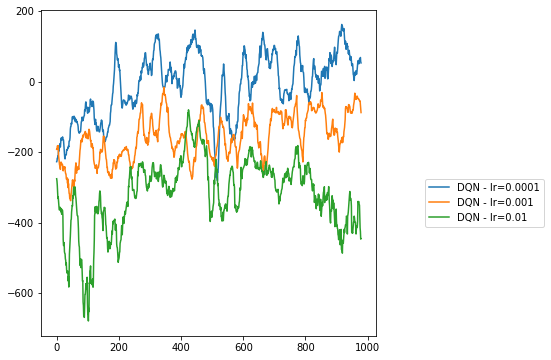

In [48]:
scores = [agentDQ1.training_scores,agentDQ2.training_scores,agentDQ3.training_scores]
names = ["DQN - lr=0.0001", "DQN - lr=0.001", "DQN - lr=0.01"]
plot_scores(scores, names)

## Adding experience replay

To get better results, we add experience replay. This means that the agent saves the actions and states for a longer period of time, and trains not only on the last events but also on previous events all the time. This prevents the agent from "forgetting" what happened in previous episodes and allows learning to be more efficient and stable. We will set the memory size to 640000 which should be enough to store all 1000 episodes. We will test 2 different learning rates and compare the results to the results of the simple DQN agents without experience replay.

In [ ]:
agentDQ4 = DQAgent(state_size, action_size, "storage/DQ_v2_lr_0.0001", gamma=0.99, learning_rate=0.0001, memory_size=640000)
agentDQ5 = DQAgent(state_size, action_size, "storage/DQ_v2_lr_0.001", gamma=0.99, learning_rate=0.001, memory_size=640000)

In [ ]:
train_agent(agentDQ4, env, episodes = 1000)

In [ ]:
train_agent(agentDQ5, env, episodes = 1000)

## Results

We can clearly see that the experience replay agents did better than the agents without experience replay, as expected. The agent with lr=0.001 was oscilating after having solved the environment in only 200 episodes, but this instability is also not indicative of a good agent.

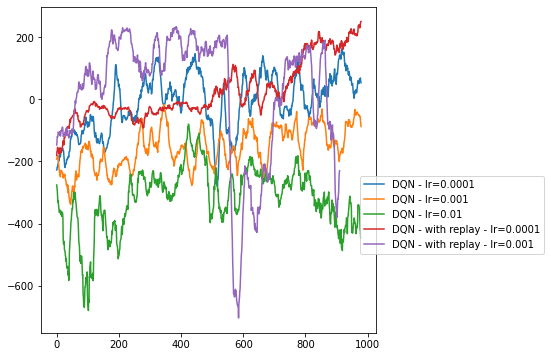

In [49]:
scores = [agentDQ1.training_scores, agentDQ2.training_scores, agentDQ3.training_scores, agentDQ4.training_scores, agentDQ5.training_scores]
names = ["DQN - lr=0.0001", "DQN - lr=0.001", "DQN - lr=0.01", "DQN - with replay - lr=0.0001", "DQN - with replay - lr=0.001"]
plot_scores(scores, names)

## Discount factor effect

Next we will take a look at the effect of the discount factor (gamma). In all previous runs we have set gamma=0.99, we will now check if decreasing or increasing the discount factor will have a better effect. We will compare these agents to the DQN agent with replay which had a learning rate of 0.001, because so far this agent has been the fastest to win the game.

In [27]:
agentDQ6 = DQAgent(state_size, action_size, "storage/DQ_v2_gamma_0.95", gamma=0.95, learning_rate=0.001, memory_size=640000)
agentDQ7 = DQAgent(state_size, action_size, "storage/DQ_v2_gamma_0.995", gamma=0.995, learning_rate=0.001, memory_size=640000)

In [ ]:
train_agent(agentDQ6, env, episodes = 500)

In [ ]:
train_agent(agentDQ7, env, episodes = 500)

## Results

The results of the discount factor test show that a value of 0.99 is ideal for the discount factor. After 500 simulations the agents with discount factor of 0.95 and 0.995 were not performing very well while the agent with discount factor 0.99 was almost able to solve the environment.

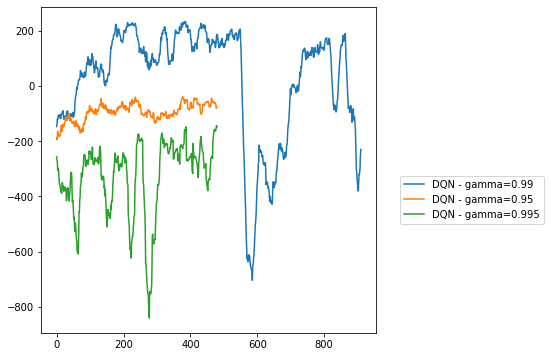

In [56]:
scores = [agentDQ5.training_scores, agentDQ6.training_scores, agentDQ7.training_scores]
names = ["DQN - gamma=0.99","DQN - gamma=0.95", "DQN - gamma=0.995"]
plot_scores(scores, names)

# DDQN - Actor Critic network

To attempt and improve the agent, we now attemt to solve the environment with an actor-critic architecture. We will use a different agent and compare the results to the existing agents.

In [62]:
class A2CAgent:
    def __init__(self, state_size, action_size, backup_dir, memory_size=640000, actor_lr=0.001, critic_lr=0.005, exploration_decay=1):
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        
        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        self.batch_size = 64
        
        self.exploration_decay = exploration_decay
        self.exploration_min = 0.01
        
        self.episodes_run = 0
        self.training_scores = []
        self.validation_scores = []
        self.exploration_rate = 1
        
        self.backup_dir         = backup_dir
        
        self.training_scores_graph_file = "Lunar_A2C_training_scores.png"
        self.memory = deque(maxlen=memory_size)

        
    def save_agent(self):
        self.actor.save(Path(self.backup_dir, "actor_model_weights"))
        self.critic.save(Path(self.backup_dir, "critic_model_weights"))
        pickle.dump(self.training_scores, open(Path(self.backup_dir, "training_scores"), "wb"))
        pickle.dump(self.validation_scores, open(Path(self.backup_dir, "validation_scores"), "wb"))
        pickle.dump([self.episodes_run], open(Path(self.backup_dir, "episodes_run"), "wb"))
        smooth = 20
        fig, ax = plt.subplots()
        ax.plot([np.mean(self.training_scores[i:i+smooth]) for i in range(len(self.training_scores) - smooth)])
        fig.savefig(Path(self.backup_dir, self.training_scores_graph_file), facecolor='white')
        plt.close(fig)

    def load_agent(self):
        self.actor = load_model(Path(self.backup_dir, "actor_model_weights"))
        self.critic = load_model(Path(self.backup_dir, "critic_model_weights"))
        self.training_scores = pickle.load(open(Path(self.backup_dir, "training_scores"), "rb"))
        self.validation_scores = pickle.load(open(Path(self.backup_dir, "validation_scores"), "rb"))
        self.episodes_run = pickle.load(open(Path(self.backup_dir, "episodes_run"), "rb"))[0]
        
    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(200, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(140, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        actor.compile(loss='mse',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(200, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(140, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
#         critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    
    # using the output of policy network, pick action stochastically
    def act(self, state, exploit=False):
        if exploit is False and self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
        policy = self.actor.predict(state, batch_size=1).flatten()
        if exploit is False and np.random.rand() <= self.exploration_rate:
            return np.random.choice(self.action_size, 1, p=policy)[0]
        else:
            return np.argmax(policy)

    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
            
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        size = self.batch_size
        sample_batch = random.sample(self.memory, size)
        
        states = np.concatenate([i[0] for i in sample_batch])
        actions = np.array([i[1] for i in sample_batch])
        rewards = np.array([i[2] for i in sample_batch])
        next_states = np.concatenate([i[3] for i in sample_batch])
        dones = np.array([i[4] for i in sample_batch])

        values = self.critic.predict(states)
        next_values = self.critic.predict(next_states)

        next_values[np.where(np.array(dones).astype(int) == 1)] = 0

        rewards = np.array(rewards).reshape(size, 1)
        calcs = rewards - values + self.discount_factor * next_values

        advantages = np.zeros((size, self.action_size))
        for i in range(size):
            advantages[i, actions[i]] = calcs[i]

        targets = rewards + self.discount_factor * next_values

        self.actor.fit(states, advantages, epochs=1, verbose=0)
        self.critic.fit(states, targets, epochs=1, verbose=0)
        

In [34]:
agentA2C_1 = A2CAgent(state_size, action_size, "storage/A2C_v1", actor_lr=0.001, critic_lr=0.001, memory_size=640000, exploration_decay=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 200)               1800      
_________________________________________________________________
dense_28 (Dense)             (None, 140)               28140     
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 1128      
Total params: 31,068
Trainable params: 31,068
Non-trainable params: 0
_________________________________________________________________


C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
train_agent(agentA2C_1, env, episodes = 500)

In [48]:
agentA2C_2 = A2CAgent(state_size, action_size, "storage/A2C_v2", actor_lr=0.001, critic_lr=0.001, memory_size=640000, exploration_decay=0.9999)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 200)               1800      
_________________________________________________________________
dense_52 (Dense)             (None, 140)               28140     
_________________________________________________________________
dense_53 (Dense)             (None, 8)                 1128      
Total params: 31,068
Trainable params: 31,068
Non-trainable params: 0
_________________________________________________________________


C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
train_agent(agentA2C_2, env, episodes = 500)

### Results

We see from the results that the A2C agents are much better than the DQN agents in solving the environment. The first agent we tried was able to reach an average score of 75 consistently. The reason that the agent wasn't able to go further than that is that the environment requires the lander to stop moving completely for 25 steps on the platform in order for the episode to be over successfully. The stochastic nature of the A2C agent did not allow this. To solve this issue I implemented an exploration decay rate which causes the A2C agent to pick the action with the highest predicted score and not pick an action stochastically after a certain number of episodes. This allows the agent to stay still on the platform and solve the environment in just over 200 episodes.

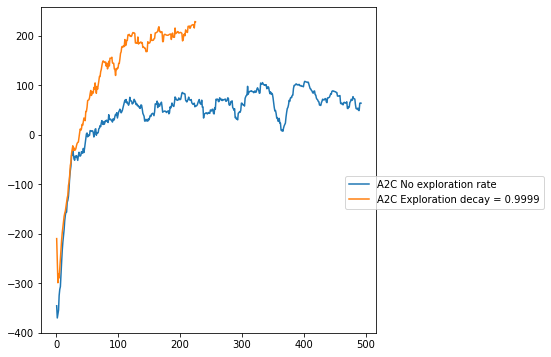

In [101]:
scores = [agentA2C_1.training_scores, agentA2C_2.training_scores]
names = ["A2C No exploration rate","A2C Exploration decay = 0.9999"]
plot_scores(scores, names)

# Sokoban

In [190]:
BLOCK_SIZE = 16
GAME_DIMENSION = 7

STATE_DIMENSION = 5

KNOWN_BLOCK_HASHES = {
    -6266362439051565649 : 1, # wall
    3505480816438514598 : 2, # empty
    -7858845969347537544 : 3, # box
    -4136424555010467604 : 4, # goal for box
    1518700435988403429 : 5, # me
    -6917688000307977437 : 6, # me on goal for box
    -5521694738111534920 : 7, # box on goal for box
}

def show_state(state):
    figure, axis = plt.subplots(1, 1,figsize=(4,4))
    axis.imshow(state)
    
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.astype(int)

def strip_border(state):
    return state.reshape(GAME_DIMENSION, GAME_DIMENSION)[1:-1, 1:-1].reshape(1, (GAME_DIMENSION - 2) ** 2)


def process_state(state):
    state = rgb2gray(state)
    new_state = []
    for i in range(0, state.shape[0], BLOCK_SIZE):
        for j in range(0, state.shape[1], BLOCK_SIZE):
            block = state[i:i+BLOCK_SIZE,j:j+BLOCK_SIZE]
            block = tuple(block.flatten())
            if hash(block) in KNOWN_BLOCK_HASHES:
                new_state.append(KNOWN_BLOCK_HASHES[hash(block)])
            else:
                print("Unknown Block")
                print(block)
                raise Exception("Unknown Block")
    return strip_border(np.array(new_state))

class SokobanEnvFinal():
    def __init__(self) -> None:
        self.env = gym.make('PushAndPull-Sokoban-v2')
        self.observation_space = (self.env.observation_space.shape[0] // BLOCK_SIZE - 2) * (self.env.observation_space.shape[1] // BLOCK_SIZE - 2)
        self.action_space = self.env.action_space
        self.state = self.env.reset()

    def reset(self):
        self.state = self.env.reset()
        return process_state(self.state)

    def step(self, action):
        prev_state = self.state.copy()
        state, reward, done, _ = self.env.step(action)
        if np.array_equal(state, prev_state):
            reward -= 0.1
        self.state = state
        return process_state(state), reward, done, {}

In [196]:
env = SokobanEnvFinal()
state_size, action_size = env.observation_space, env.action_space.n
action_size

13

In [207]:
agentA2C_sokoban = A2CAgent(state_size, action_size, "storage/A2C_sokoban_v1", actor_lr=0.001, critic_lr=0.001, memory_size=640000, exploration_decay=1)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 200)               5200      
_________________________________________________________________
dense_136 (Dense)            (None, 140)               28140     
_________________________________________________________________
dense_137 (Dense)            (None, 13)                1833      
Total params: 35,173
Trainable params: 35,173
Non-trainable params: 0
_________________________________________________________________


C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
train_agent(agentA2C_sokoban, env, episodes = 500, max_timestamps_per_game=50)

In [ ]:
train_agent(agentA2C_sokoban, env, episodes = 50000, max_timestamps_per_game=50)

C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bar\anaconda3\envs\tf-gpu2\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


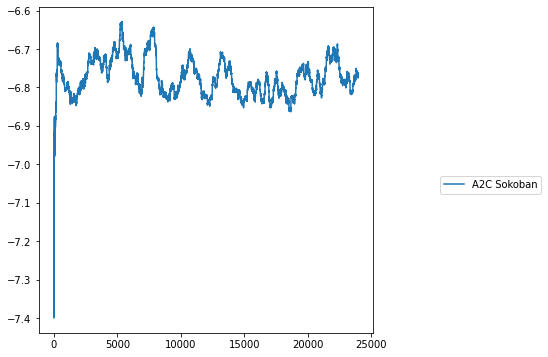

In [219]:
scores = [agentA2C_sokoban.training_scores]
names = ["A2C Sokoban"]
plot_scores(scores, names, smooth = 1000)

### Results

We see from the results that the A2C agent which was able to successfully solve the Lunar Lander environment is not able to solve the Sokoban environment in 25000 episodes. It is possible that running for more iterations we will see some learning but it is preferable to improve the agent first.

In [169]:
env.reset()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 2, 2, 3, 3, 2, 4, 2, 2,
        5, 2, 2]])

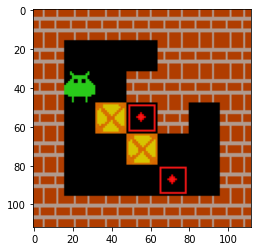

In [224]:
show_state(env.state)

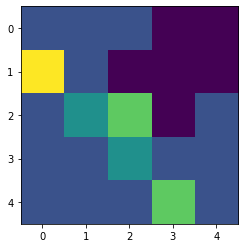

In [223]:
show_state(process_state(env.state).reshape(5,5))